Found 9049 images belonging to 6 classes.
Found 1063 images belonging to 6 classes.
Found 537 images belonging to 6 classes.
📊 Model will train on 6 classes: ['Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato_healthy']
✅ Found saved model at tomato_cnn_model.keras, loading it instead of retraining...

🔎 Evaluating on Test Data...


C:\Users\danis\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 176ms/step - accuracy: 0.9391 - loss: 0.1670
✅ Test Accuracy: 95.90%
❌ Test Loss: 0.1173
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 193ms/step


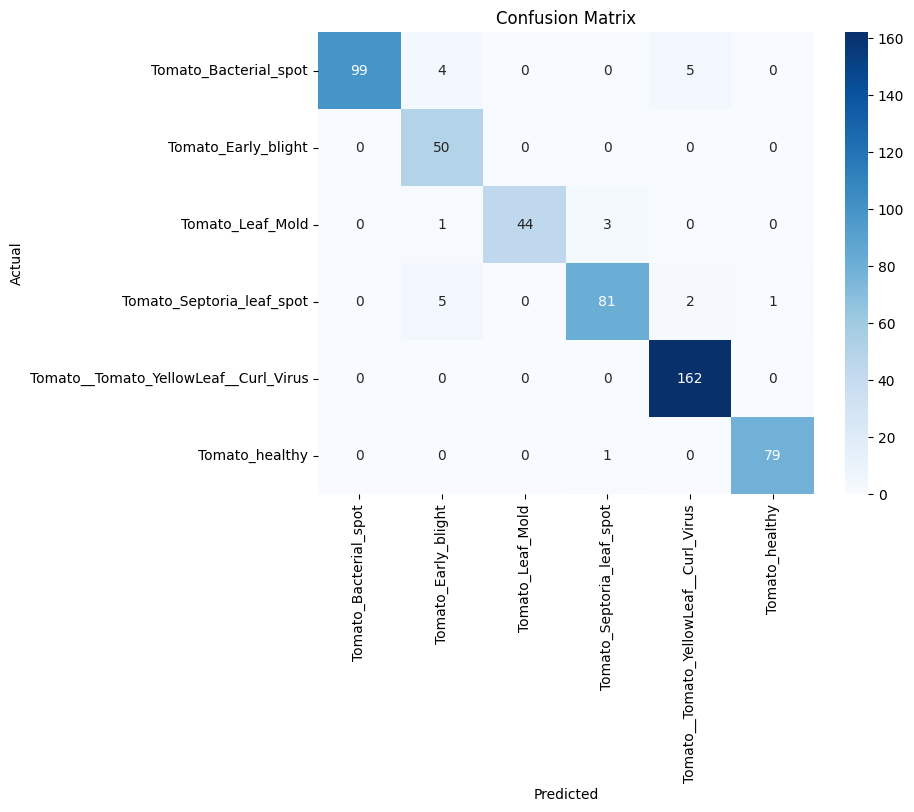


📊 Classification Report:
                                       precision    recall  f1-score   support

                Tomato_Bacterial_spot       1.00      0.92      0.96       108
                  Tomato_Early_blight       0.83      1.00      0.91        50
                     Tomato_Leaf_Mold       1.00      0.92      0.96        48
            Tomato_Septoria_leaf_spot       0.95      0.91      0.93        89
Tomato__Tomato_YellowLeaf__Curl_Virus       0.96      1.00      0.98       162
                       Tomato_healthy       0.99      0.99      0.99        80

                             accuracy                           0.96       537
                            macro avg       0.96      0.96      0.95       537
                         weighted avg       0.96      0.96      0.96       537




📂 Enter image path to predict (or press Enter / type q to quit):  E:\Major Project\septoria.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
🔍 Prediction: Tomato_Septoria_leaf_spot (79.44%)


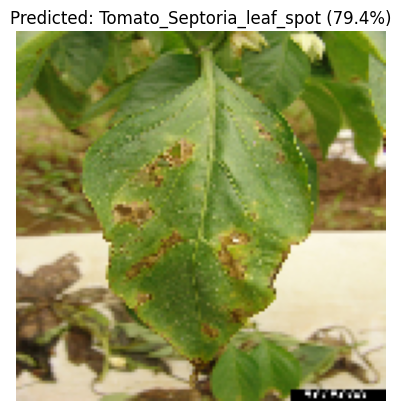


📂 Enter image path to predict (or press Enter / type q to quit):  


👋 Exiting prediction loop.


In [13]:
import os
import shutil
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import ModelCheckpoint

# ============================
# PATHS
# ============================
dataset_dir = r"E:\DANISH\Major Project\DATA\PlantVillage"          # Original dataset (unsplit)
base_dir = r"E:\DANISH\Major Project\DATA\PlantVillage_split"       # Split dataset output
MODEL_PATH = "tomato_cnn_model.keras"
HISTORY_PATH = "training_history.pkl"

# ============================
# DATASET SPLITTING FUNCTION
# ============================
def split_dataset(dataset_dir, base_dir, train_size=0.85, val_size=0.10, test_size=0.05):
    if os.path.exists(base_dir):
        shutil.rmtree(base_dir)
    os.makedirs(base_dir, exist_ok=True)

    train_dir = os.path.join(base_dir, "train")
    val_dir = os.path.join(base_dir, "val")
    test_dir = os.path.join(base_dir, "test")

    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    print("🔄 Splitting dataset...")

    for category in os.listdir(dataset_dir):
        category_path = os.path.join(dataset_dir, category)
        if not os.path.isdir(category_path):
            continue

        images = os.listdir(category_path)
        random.shuffle(images)

        total = len(images)
        if total == 0:
            continue

        train_split = int(train_size * total)
        val_split = int(val_size * total)
        test_split = total - train_split - val_split

        if test_split == 0 and total > 1:
            test_split = 1
            train_split -= 1

        train_images = images[:train_split]
        val_images = images[train_split:train_split+val_split]
        test_images = images[train_split+val_split:]

        for folder, file_list in zip(
            [train_dir, val_dir, test_dir],
            [train_images, val_images, test_images]
        ):
            category_folder = os.path.join(folder, category)
            os.makedirs(category_folder, exist_ok=True)
            for img in file_list:
                shutil.copy(os.path.join(category_path, img), os.path.join(category_folder, img))

    print("✅ Dataset split done!")

# ============================
# DATA GENERATORS
# ============================
def create_generators(base_dir, img_size=128, batch_size=32):
    train_datagen = ImageDataGenerator(rescale=1./255)
    val_datagen = ImageDataGenerator(rescale=1./255)
    test_datagen = ImageDataGenerator(rescale=1./255)

    train_gen = train_datagen.flow_from_directory(
        os.path.join(base_dir, "train"),
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode="categorical"
    )
    val_gen = val_datagen.flow_from_directory(
        os.path.join(base_dir, "val"),
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode="categorical"
    )
    test_gen = test_datagen.flow_from_directory(
        os.path.join(base_dir, "test"),
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode="categorical",
        shuffle=False
    )

    if train_gen.samples == 0 or val_gen.samples == 0 or test_gen.samples == 0:
        print("⚠️ One of the splits has 0 images. Re-splitting dataset...")
        split_dataset(dataset_dir, base_dir)
        return create_generators(base_dir, img_size, batch_size)

    return train_gen, val_gen, test_gen

# ============================
# MODEL
# ============================
def build_model(input_shape=(128, 128, 3), num_classes=6):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3,3), activation="relu", input_shape=input_shape),
        tf.keras.layers.MaxPooling2D(2,2),

        tf.keras.layers.Conv2D(64, (3,3), activation="relu"),
        tf.keras.layers.MaxPooling2D(2,2),

        tf.keras.layers.Conv2D(128, (3,3), activation="relu"),
        tf.keras.layers.MaxPooling2D(2,2),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation="softmax")
    ])

    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model

# ============================
# VISUALIZATION FUNCTIONS
# ============================
def plot_training_curves(history_dict):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(history_dict["accuracy"], label="Train Acc")
    plt.plot(history_dict["val_accuracy"], label="Val Acc")
    plt.title("Accuracy")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history_dict["loss"], label="Train Loss")
    plt.plot(history_dict["val_loss"], label="Val Loss")
    plt.title("Loss")
    plt.legend()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, class_labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

# ============================
# PREDICT FUNCTION
# ============================
def predict_image(model, img_path, class_labels, img_size=128):
    img = load_img(img_path, target_size=(img_size, img_size))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)[0]
    confidence = np.max(prediction)

    print(f"🔍 Prediction: {class_labels[predicted_class]} ({confidence*100:.2f}%)")

    plt.imshow(img)
    plt.title(f"Predicted: {class_labels[predicted_class]} ({confidence*100:.1f}%)")
    plt.axis("off")
    plt.show()

# ============================
# MAIN PIPELINE
# ============================
train_gen, val_gen, test_gen = create_generators(base_dir)
num_classes = train_gen.num_classes
class_labels = list(train_gen.class_indices.keys())
print(f"📊 Model will train on {num_classes} classes: {class_labels}")

if os.path.exists(MODEL_PATH):
    print(f"✅ Found saved model at {MODEL_PATH}, loading it instead of retraining...")
    model = tf.keras.models.load_model(MODEL_PATH)

    if os.path.exists(HISTORY_PATH):
        with open(HISTORY_PATH, "rb") as f:
            saved_history = pickle.load(f)
        plot_training_curves(saved_history)

else:
    print("⚡ Training model from scratch...")
    model = build_model(num_classes=num_classes)
    checkpoint = ModelCheckpoint(MODEL_PATH, save_best_only=True, monitor="val_accuracy", mode="max")

    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=20,
        callbacks=[checkpoint]
    )

    with open(HISTORY_PATH, "wb") as f:
        pickle.dump(history.history, f)

    plot_training_curves(history.history)

# ============================
# EVALUATION
# ============================
print("\n🔎 Evaluating on Test Data...")
if test_gen.samples == 0:
    print("⚠️ No test images found. Skipping evaluation.")
else:
    test_loss, test_acc = model.evaluate(test_gen, verbose=1)
    print(f"✅ Test Accuracy: {test_acc*100:.2f}%")
    print(f"❌ Test Loss: {test_loss:.4f}")

    # Predictions for confusion matrix
    y_true = test_gen.classes
    y_pred = np.argmax(model.predict(test_gen), axis=1)

    plot_confusion_matrix(y_true, y_pred, class_labels)
    print("\n📊 Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_labels))

# ============================
# USER PREDICTION LOOP
# ============================
while True:
    img_path = input("\n📂 Enter image path to predict (or press Enter / type q to quit): ").strip().strip('"').strip("'")
    if img_path.lower() == "q" or img_path == "":
        print("👋 Exiting prediction loop.")
        break
    if not os.path.exists(img_path):
        print("⚠️ File not found, try again!")
        continue
    predict_image(model, img_path, class_labels)
